## Step C

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd 
import skimage.morphology as sk
from operator import itemgetter

The ```compute_all_keypoints``` function calculates all keypoints of all query and train images and stores them in a dictionary, in order to easily access them later.

In [3]:
def compute_all_keypoints(query_imgs, train_imgs, sift):

    img_dict = {}

    for img in query_imgs:
        file = 'models/' + img + '.jpg'
        query = cv2.imread(file, 0)
        kp, des = sift.detectAndCompute(query, None)
        img_dict[img] = {'kp': kp, 'des': des, 'shape': query.shape}

    for img in train_imgs:
        file = 'scenes/' + img
        train = cv2.imread(file, 0)
        kp, des = sift.detectAndCompute(train, None)
        img_dict[img] = {'kp': kp, 'des': des, 'shape': train.shape}

    return img_dict

The ```apply_ratio_test``` function takes all the matches found between the query and the train image, it chooses the good ones with the usual ratio test and it stores them in a dictionary using the indexes of the query keypoints as keys and the indexes of the train keypoints as values.

In [4]:
def apply_ratio_test(all_matches, img_height):

    good_matches = {}      #map of matches kp_train_idx -> kp_query_idx
    accurate_matches = []

    precise_coeff = 0.6      

    if img_height >= 600:
        lowe_coeff = 0.7
    elif img_height >= 400:
        lowe_coeff = 0.8
    else:
        lowe_coeff = 0.9

    for m, n in all_matches:
        if m.distance < lowe_coeff * n.distance:
            good_matches[m.queryIdx] = m.trainIdx
        if m.distance < precise_coeff * n.distance:
            accurate_matches.append(m)

            
    return good_matches, accurate_matches

The ```compute_entry_hough_space``` function maps a point into the 4-dimensional Hough space, the ```create_hough_space``` function computes the Hough space entries for all keypoints.

In [5]:
def compute_entry_hough_space(kp_q, kp_t, q_xc, q_yc):

    entry = {}

    v = ((q_xc - kp_q.pt[0]), (q_yc - kp_q.pt[1]))
    scale_ratio = kp_t.size / kp_q.size
    delta_angle = kp_t.angle - kp_q.angle
    x_c = kp_t.pt[0] + scale_ratio * (np.cos(delta_angle) * v[0] - np.sin(delta_angle) * v[1])
    y_c = kp_t.pt[1] + scale_ratio * (np.sin(delta_angle) * v[0] + np.cos(delta_angle) * v[1])

    entry['x_c'] = x_c
    entry['y_c'] = y_c
    entry['scale_ratio'] = scale_ratio
    entry['delta_angle'] = delta_angle
    
    return entry 

In [6]:
def create_hough_space(good_matches, kp_query, kp_train, query_xc, query_yc):
    
    hough_space = {}     #map of hough space kp_train_idx -> map name-values

    for t_idx, q_idx in good_matches.items():
        hough_space[t_idx] = compute_entry_hough_space(kp_query[q_idx], kp_train[t_idx], query_xc, query_yc)
    
    return hough_space

The ```compute_bins``` function partitions the 4-dimensional Hough space into discrete bins.

In [7]:
def compute_accurate_scale(accu_matches, kp_q, kp_t):

    accurate_scale_data = []

    for m in accu_matches:

        accurate_scale_data.append(kp_t[m.queryIdx].size/kp_q[m.trainIdx].size) 

    return accurate_scale_data

In [8]:
def compute_bins(hough_space,query_shape,train_shape,accurate_scale_data):

    values = {}
          
    counts_scale, bins_scale, patches_size = plt.hist(accurate_scale_data, bins='auto')
    img_scale = np.mean([bins_scale[np.argmax(counts_scale)], bins_scale[np.argmax(counts_scale) + 1]])
    plt.close();

    data_angle = [entry['delta_angle'] for entry in hough_space.values()]
    counts_angle, bins_angle, patches_angle = plt.hist(data_angle, bins='auto')
    plt.close();

    x_bin_size = img_scale * query_shape[1] * BIN_PRECISION_FACTOR
    y_bin_size = img_scale * query_shape[0] * BIN_PRECISION_FACTOR
    x_bins = int(np.ceil(train_shape[1] / x_bin_size) + 2)
    y_bins = int(np.ceil(train_shape[0] / y_bin_size) + 2)
    x_min = train_shape[1] / 2 - x_bins / 2 * x_bin_size
    y_min = train_shape[0] / 2 - y_bins / 2 * y_bin_size

    angle_bin_size = np.std(data_angle) * ANGLE_BIN_SIZE_COEFF
    angle_bin_center = np.mean(data_angle)
    angle_min = angle_bin_center - ANGLE_BINS / 2 * angle_bin_size
    angle_max = angle_bin_center + ANGLE_BINS / 2 * angle_bin_size

    data_scale = [entry['scale_ratio'] for entry in hough_space.values()]
    scale_bin_size = np.std(data_scale) * SCALE_BIN_SIZE_COEFF
    scale_bin_center = np.mean(data_scale)
    scale_min = 0 
    scale_max = scale_bin_center * 2 
    scale_bins = int((scale_max - scale_min) / scale_bin_size)

    values['x_bins'] = x_bins
    values['y_bins'] = y_bins
    values['x_min'] = x_min
    values['y_min'] = y_min
    values['x_bin_size'] = x_bin_size
    values['y_bin_size'] = y_bin_size
    values['scale_bins'] = scale_bins
    values['scale_min'] = scale_min
    values['scale_bin_size'] = scale_bin_size
    values['angle_min'] = angle_min
    values['angle_bin_size'] = angle_bin_size 

    return values

The ```voting``` function attributes 16 bins to each point in the 4-dimensional Hough space.

In [9]:
def voting(b,h_s):

    accumulator = np.zeros((b['x_bins'], b['y_bins'], ANGLE_BINS, b['scale_bins']))

    votes = {}

    for idx, v in h_s.items():
        try:
            for x in range(-1, 2):
                for y in range(-1, 2):
                    for z in range(-1, 2):
                        for w in range(-1, 2):                
                            i = int(np.floor((v['x_c'] - b['x_min'] + x * b['x_bin_size']) / b['x_bin_size']))
                            j = int(np.floor((v['y_c'] - b['y_min'] + y * b['y_bin_size']) / b['y_bin_size']))
                            k = int(np.floor((v['delta_angle'] - b['angle_min'] + z * b['angle_bin_size']) / b['angle_bin_size']))
                            l = int(np.floor((v['scale_ratio'] - b['scale_min'] + w * b['scale_bin_size']) / b['scale_bin_size']))
                            if i >= 0 and j >= 0 and k >= 0 and l >= 0:
                                accumulator[i, j, k, l] += 1
                                votes[(i, j, k, l)] = votes.get((i, j, k, l), [])
                                votes[(i, j, k, l)].append(idx)
        except: pass
    
    return accumulator, votes   

The ```find_all_correspondeces``` function computes all the correspondeces between query points and train points that voted for a local maxima.

In [10]:
def find_all_correspondeces(query_imgs, train_img, img_dict, bf):

    global_correspondences = []  #list of lists of all correspondent point of every image  

    for query_img in query_imgs:
        
        #compute keypoints and desctiptors for query and train
        kp_query, des_query = img_dict[query_img]['kp'], img_dict[query_img]['des']
        kp_train, des_train = img_dict[train_img]['kp'], img_dict[train_img]['des']

        #match descriptors between the two images 
        all_matches = bf.knnMatch(des_train, des_query, k=2)

        #create map of matching keypoint indexes surviving the lowe ratio test 
        good_matches,accurate_matches = apply_ratio_test(all_matches, img_dict[query_img]['shape'][0])

        #barycenter of found query keypoint 
        query_xc = np.mean(list(kp_query[p].pt[0] for _, p in good_matches.items()))
        query_yc = np.mean(list(kp_query[p].pt[1] for _, p in good_matches.items()))

        #create hough space 
        hough_space = create_hough_space(good_matches, kp_query, kp_train, query_xc, query_yc)
        
        #do not go on with this query image if the number of entries in the hough space are below a certain threshold
        if len(hough_space) < HOUGH_T: continue

        #compute the most probable scale value using less, but more accurate, points than the ones used in the voting procedure
        accurate_scale_data = compute_accurate_scale(accurate_matches, kp_query, kp_train)

        #compute all the values related to the size 
        bins_values = compute_bins(hough_space, img_dict[query_img]['shape'], img_dict[train_img]['shape'], accurate_scale_data)

        #create and populate accumulator with voting by each entry of the hough space 
        accumulator, votes= voting(bins_values, hough_space)

        #compute local maxima of the 4d accumulator 
        mask = sk.local_maxima(accumulator)
        accumulator[mask != 1] = 0

        #store in a list all the correspondeces between query points and train points that voted for a local maxima 
        #the list contains: number of votes that a local maxima bin has received, name of query image, list of query and train keypoints which voted for that bin 

        for b in list(np.argwhere(accumulator >= T_Q)):     #thresholding the accumulator to come up with few maxima 
            keypoint_index_list = votes[tuple(b)]       #all query keypoint who voted for a local maxima bin 
            correspondence_list = [(kp_train[k], kp_query[good_matches[k]]) for k in keypoint_index_list]
            global_correspondences.append([accumulator[tuple(b)], query_img, correspondence_list])

    g_c = sorted(global_correspondences, key=itemgetter(0), reverse=True )    #sorted correspondences based on number of votes found in                                                                                 local maxima bins 

    return g_c 

The ```check_matches``` function orders the good matches in decreasing number of keypoints and it runs a series of tests on them, checking the geometric arrangement and the color consistency.

In [11]:
def check_matches(correspondences, train_img):

    train_file = 'scenes/' + train_img
    train_bgr = cv2.imread(train_file)

    areas = []               #list of ROI area of every query image in the train image
    dimensions = []          #list of tuple (width, height) for each detected box 
    recognised = {}          #dict query_name -> list of projected query vertex into train image

    for entry in correspondences:
        try:

            query_file = 'models/' + entry[1] + '.jpg'
            query_bgr = cv2.imread(query_file)
            
            #compute query color over the three different channel to function as a reference for the recognised ROI on scene image 
            query_HSV = cv2.cvtColor(query_bgr, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(query_HSV, (0, 150, 150), (179, 255,255))
            query_masked = cv2.bitwise_and(query_bgr, query_bgr, mask = mask)
            query_masked = cv2.cvtColor(query_masked, cv2.COLOR_BGR2RGB)

            query_temp_red = query_masked[:, :, 0].ravel()
            query_temp_green = query_masked[:, :, 1].ravel()
            query_temp_blue = query_masked[:, :, 2].ravel()
            query_color_red = (query_temp_red[query_temp_red > 0]).mean(axis=0)
            query_color_green = (query_temp_green[query_temp_green > 0]).mean(axis=0)
            query_color_blue = (query_temp_blue[query_temp_blue > 0]).mean(axis=0)

            #compute homography through correspondent keypoints
            src_pts = np.float32([e[1].pt for e in entry[2]]).reshape(-1, 1, 2)
            dst_pts = np.float32([e[0].pt for e in entry[2]]).reshape(-1, 1, 2)
            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            h, w, d = query_bgr.shape
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts, M)

            #determine center of the train ROI matching with the image query
            center = tuple((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4 for i in (0, 1))

            #determine extreme points of the quadrilateral shape of query image projected into train scene (_stretch parameters are bounded to stay inside the scene image shape while can happen that normal ones (x_min, ecc) lay outside image dimensions )
            x_min = int(min(dst[0, 0, 0], dst[1, 0, 0]))
            y_min = int(min(dst[0, 0, 1], dst[3, 0, 1]))
            x_max = int(max(dst[2, 0, 0], dst[3, 0, 0]))
            y_max = int(max(dst[1, 0, 1], dst[2, 0, 1]))
            
            x_min_stretch = int(max((dst[0, 0, 0] + dst[1, 0, 0]) / 2, 0))
            y_min_stretch = int(max((dst[0, 0, 1] + dst[3, 0, 1]) / 2, 0))
            x_max_stretch = int(min((dst[2, 0, 0] + dst[3, 0, 0]) / 2, train_bgr.shape[1]))
            y_max_stretch = int(min((dst[1, 0, 1] + dst[2, 0, 1]) / 2, train_bgr.shape[0]))

            #compute main color of the scene ROI to be compared with query color over the three channels 
            train_crop = train_bgr[y_min_stretch:y_max_stretch, x_min_stretch:x_max_stretch] 
            
            train_crop_HSV = cv2.cvtColor(train_crop,cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(train_crop_HSV, (0, 150, 150), (179, 255,255))
            train_crop_masked = cv2.bitwise_and(train_crop,train_crop, mask = mask)
            train_crop_masked = cv2.cvtColor(train_crop_masked,cv2.COLOR_BGR2RGB)

            train_crop_temp_red = train_crop_masked[:, :, 0].ravel()
            train_crop_temp_green = train_crop_masked[:, :, 1].ravel()
            train_crop_temp_blue = train_crop_masked[:, :, 2].ravel()
            train_crop_color_red = (train_crop_temp_red[train_crop_temp_red > 0]).mean(axis=0)
            train_crop_color_green = (train_crop_temp_green[train_crop_temp_green > 0]).mean(axis=0)
            train_crop_color_blue = (train_crop_temp_blue[train_crop_temp_blue > 0]).mean(axis=0)

            color_diff = abs(query_color_red - train_crop_color_red) + abs(query_color_green - train_crop_color_green) + abs(query_color_blue - train_crop_color_blue)
        
            #compute area alongside width and height of the query ROI
            area = 0
            for i in range(3):
                area += dst[i, 0, 0] * dst[i + 1, 0, 1] - dst[i + 1, 0, 0] * dst[i, 0, 1]
            area += dst[3, 0, 0] * dst[0, 0, 1] - dst[0, 0, 0] * dst[3, 0, 1]
            area = abs(area / 2)
            width = x_max - x_min
            height = y_max - y_min

            #recognise a query in the scene only if it's ROI color it's similar to the query color and it does not overlap with another already placed box
            temp = True 
            if color_diff < COLOR_T\
                and dst[0, 0, 0] < dst[3, 0, 0]\
                and dst[1, 0, 0] < dst[2, 0, 0]\
                and dst[0, 0, 1] < dst[1, 0, 1]\
                and dst[3, 0, 1] < dst[2, 0, 1]:
                areas.append(area)
                dimensions.append((width, height))
                if area / areas[0] > AREA_MIN and area / areas[0] < AREA_MAX\
                    and width / dimensions[0][0] > DIM_MIN and width / dimensions[0][0] < DIM_MAX\
                    and height / dimensions[0][1] > DIM_MIN and height / dimensions[0][1] < DIM_MAX:
                    for k, v in recognised.items():
                        for corners in v:
                            r_center = tuple((corners[0, 0, i] + corners[1, 0, i] + corners[2, 0, i] + corners[3, 0, i]) / 4 for i in (0, 1))
                            if (center[0] > min(corners[0, 0, 0], corners[1, 0, 0]) and center[0] < max(corners[2, 0, 0], corners[3, 0, 0])\
                                and center[1] > min(corners[0, 0, 1], corners[3, 0, 1]) and center[1] < max(corners[1, 0, 1], corners[2, 0, 1]))\
                                or (r_center[0] > x_min and r_center[0] < x_max\
                                and r_center[1] > y_min and r_center[1] < y_max):
                                temp = False
                                break
                    if temp:
                        recognised[entry[1]] = recognised.get(entry[1], [])  
                        recognised[entry[1]].append(dst)
        except: pass
    
    return recognised

The ```print_matches``` function takes all the recognised images and prints their details, i.e. their position, width, and height.

In [12]:
def print_matches(train_img, query_imgs, recognised, true_imgs, verbose):
    
    print('Scene: ' + train_img[0:2] + '\n')

    for query_img in query_imgs:
                     
        total = len(recognised.get(query_img, []))
        true_total = true_imgs[train_img][query_img]

        if total != true_total:
            print('\033[1m' + 'Product ' + query_img + ' – ' + str(total) + '/' + str(true_total) + ' instances found' + '\033[0m')
        elif total > 0 or verbose == True:
            print('Product ' + query_img + ' – ' + str(total) + '/' + str(true_total) + ' instances found')
            
        for j in range(total):
            dst = recognised[query_img][j]
            center = tuple(int((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4) for i in (0, 1))
            w = int(((dst[3, 0, 0] - dst[0, 0, 0]) + (dst[2, 0, 0] - dst[1, 0, 0])) /2)
            h = int(((dst[1, 0, 1] - dst[0, 0, 1]) + (dst[2, 0, 1] - dst[3, 0, 1])) /2)
            print('\t' + 'Position: ' + str(center)\
                 + '\t' + 'Width: ' + str(w)\
                 + '\t' + 'Height: ' + str(h))

The ```draw_matches``` function draws on the train image the boxes' homographies and the numbers corresponding to the query images.

In [13]:
def draw_matches(recognised, train_img, color):

    train_file = 'scenes/' + train_img

    #if color option is enabled all the results are printed on colored images 
    if color == True:
        train_bgr = cv2.imread(train_file)
        train_temp = cv2.cvtColor(train_bgr, cv2.COLOR_BGR2RGB)
        train_rgb = np.zeros(train_bgr.shape, train_bgr.dtype)
        for y in range(train_temp.shape[0]):
            for x in range(train_temp.shape[1]):
                for c in range(train_temp.shape[2]):
                    train_rgb[y, x, c] = np.clip(0.5 * train_temp[y, x, c], 0, 255)
    else:
        train_gray = cv2.imread(train_file, 0)
        train_rgb = cv2.cvtColor(train_gray // 2, cv2.COLOR_GRAY2RGB)
    
    #for each recognised box in the scene draw the bounding box with its number in it 
    for k, v in recognised.items():

        for dst in v:

            train_rgb = cv2.polylines(train_rgb, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(train_rgb, k,\
                        (int((dst[3, 0, 0] - dst[0, 0, 0]) * 0.25 + dst[0, 0, 0]), int((dst[1, 0, 1] - dst[0, 0, 1]) * 0.67 + dst[0, 0, 1])),\
                        font, 1 if train_img[0] == 'h' else 5, (0, 255, 0), 2 if train_img[0] == 'h' else 10, cv2.LINE_AA)
           
    plt.imshow(train_rgb),plt.show();
        
    if color == True:
        
        cv2.imwrite('output/step_C/' + train_img, cv2.cvtColor(train_rgb, cv2.COLOR_RGB2BGR))

The ```step_C``` function takes the lists of query and train images and performs the product recognition.

In [14]:
 def step_C(query_imgs, train_imgs, true_imgs, verbose, color):

    sift = cv2.xfeatures2d.SIFT_create()

    bf = cv2.BFMatcher()        #descriptor matcher 

    img_dict = compute_all_keypoints(query_imgs, train_imgs, sift)    #compute all keypoints for all images once for all 

    for train_img in train_imgs:

        g_c = find_all_correspondeces(query_imgs, train_img, img_dict, bf)

        recognised = check_matches(g_c, train_img)
        
        print_matches(train_img, query_imgs, recognised, true_imgs, verbose)
            
        draw_matches(recognised, train_img, color)
        
        print('\n')

Parameters:

In [15]:
HOUGH_T = 10
AREA_MIN = 0.4
AREA_MAX = 2
DIM_MIN = 0.4
DIM_MAX = 1.8
BIN_PRECISION_FACTOR = 0.25
ANGLE_BINS = 7
ANGLE_BIN_SIZE_COEFF = 0.1
SCALE_BIN_SIZE_COEFF = 0.1
T_Q = 5
COLOR_T = 120

In [16]:
query_imgs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26']
train_imgs = ['e1.png', 'e2.png', 'e3.png', 'e4.png', 'e5.png',\
              'm1.png', 'm2.png', 'm3.png', 'm4.png', 'm5.png',\
              'h1.jpg', 'h2.jpg', 'h3.jpg', 'h4.jpg', 'h5.jpg']
true_imgs = {
    'e1.png': {'0': 1, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 1, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0},
    'e2.png': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 1, '25': 1, '26': 1},
    'e3.png': {'0': 1, '1': 1, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 1, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0},
    'e4.png': {'0': 1, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 1, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 1, '26': 1},
    'e5.png': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 1, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 1, '26': 0},
    'm1.png': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 2, '25': 1, '26': 1},
    'm2.png': {'0': 1, '1': 2, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 1, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0},
    'm3.png': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 1, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 2, '26': 1},
    'm4.png': {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 2, '25': 2, '26': 1},
    'm5.png': {'0': 0, '1': 2, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 1, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 1, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 2, '26': 0},
    'h1.jpg': {'0': 2, '1': 1, '2': 2, '3': 2, '4': 2, '5': 2, '6': 0, '7': 2, '8': 2, '9': 2, '10': 2, '11': 2, '12': 1, '13': 2, '14': 2, '15': 1, '16': 2, '17': 2, '18': 1, '19': 1, '20': 2, '21': 2, '22': 2, '23': 0, '24': 0, '25': 0, '26': 2},
    'h2.jpg': {'0': 2, '1': 1, '2': 0, '3': 3, '4': 2, '5': 2, '6': 0, '7': 2, '8': 2, '9': 2, '10': 2, '11': 2, '12': 2, '13': 2, '14': 1, '15': 1, '16': 2, '17': 2, '18': 1, '19': 1, '20': 2, '21': 2, '22': 2, '23': 0, '24': 0, '25': 0, '26': 2},
    'h3.jpg': {'0': 2, '1': 1, '2': 0, '3': 3, '4': 2, '5': 2, '6': 0, '7': 2, '8': 2, '9': 2, '10': 2, '11': 2, '12': 1, '13': 2, '14': 1, '15': 1, '16': 1, '17': 2, '18': 1, '19': 1, '20': 2, '21': 2, '22': 2, '23': 0, '24': 0, '25': 0, '26': 2},
    'h4.jpg': {'0': 1, '1': 1, '2': 2, '3': 2, '4': 2, '5': 2, '6': 0, '7': 2, '8': 2, '9': 2, '10': 2, '11': 2, '12': 1, '13': 2, '14': 2, '15': 1, '16': 2, '17': 2, '18': 1, '19': 1, '20': 2, '21': 2, '22': 2, '23': 0, '24': 0, '25': 0, '26': 2},
    'h5.jpg': {'0': 2, '1': 1, '2': 0, '3': 3, '4': 2, '5': 2, '6': 0, '7': 2, '8': 2, '9': 1, '10': 2, '11': 2, '12': 1, '13': 2, '14': 1, '15': 1, '16': 2, '17': 2, '18': 1, '19': 1, '20': 2, '21': 2, '22': 2, '23': 0, '24': 0, '25': 0, '26': 2},
}



Scene: e1

Product 0 – 1/1 instances found
	Position: (163, 214)	Width: 311	Height: 432
Product 11 – 1/1 instances found
	Position: (444, 168)	Width: 301	Height: 388


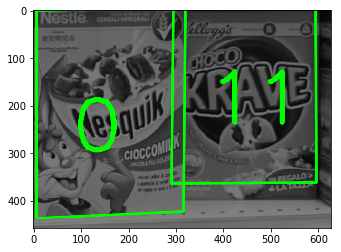



Scene: e2

Product 24 – 1/1 instances found
	Position: (167, 219)	Width: 334	Height: 489
Product 25 – 1/1 instances found
	Position: (878, 231)	Width: 312	Height: 440
Product 26 – 1/1 instances found
	Position: (538, 218)	Width: 333	Height: 486


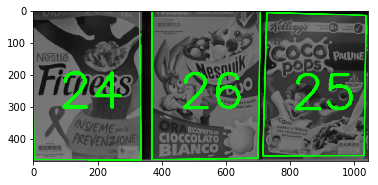



Scene: e3

Product 0 – 1/1 instances found
	Position: (171, 236)	Width: 325	Height: 440
Product 1 – 1/1 instances found
	Position: (808, 195)	Width: 297	Height: 401
Product 11 – 1/1 instances found
	Position: (476, 187)	Width: 303	Height: 394


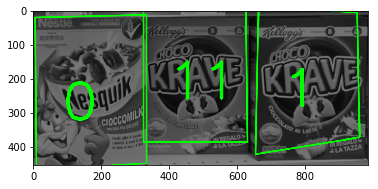



Scene: e4

Product 0 – 1/1 instances found
	Position: (158, 739)	Width: 324	Height: 440
Product 11 – 1/1 instances found
	Position: (463, 692)	Width: 302	Height: 395
Product 25 – 1/1 instances found
	Position: (555, 209)	Width: 323	Height: 451
Product 26 – 1/1 instances found
	Position: (205, 195)	Width: 340	Height: 493


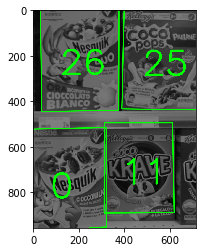



Scene: e5

Product 19 – 1/1 instances found
	Position: (504, 190)	Width: 296	Height: 384
Product 25 – 1/1 instances found
	Position: (161, 229)	Width: 321	Height: 448


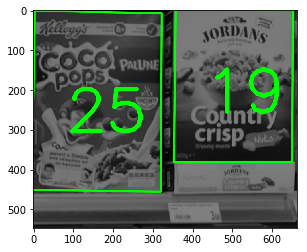



Scene: m1

Product 24 – 2/2 instances found
	Position: (550, 219)	Width: 334	Height: 489
	Position: (184, 214)	Width: 351	Height: 499
Product 25 – 1/1 instances found
	Position: (1260, 232)	Width: 312	Height: 441
Product 26 – 1/1 instances found
	Position: (921, 218)	Width: 333	Height: 486


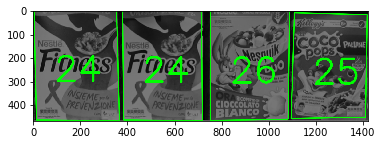



Scene: m2

Product 0 – 1/1 instances found
	Position: (178, 300)	Width: 343	Height: 449
Product 1 – 2/2 instances found
	Position: (848, 258)	Width: 313	Height: 410
	Position: (1180, 255)	Width: 302	Height: 407
Product 11 – 1/1 instances found
	Position: (511, 250)	Width: 307	Height: 401


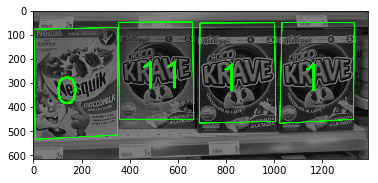



Scene: m3

Product 19 – 1/1 instances found
	Position: (1232, 190)	Width: 295	Height: 383
Product 25 – 2/2 instances found
	Position: (558, 222)	Width: 336	Height: 457
	Position: (889, 228)	Width: 321	Height: 446
Product 26 – 1/1 instances found
	Position: (195, 206)	Width: 354	Height: 505


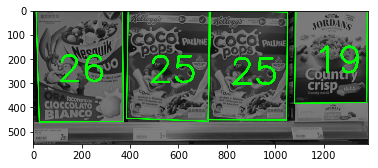



Scene: m4

Product 24 – 2/2 instances found
	Position: (161, 191)	Width: 365	Height: 508
	Position: (540, 196)	Width: 348	Height: 498
Product 25 – 2/2 instances found
	Position: (1588, 215)	Width: 309	Height: 438
	Position: (1271, 209)	Width: 323	Height: 449
Product 26 – 1/1 instances found
	Position: (921, 195)	Width: 340	Height: 493


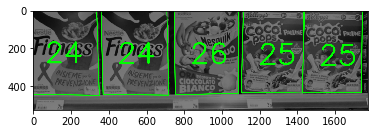



Scene: m5

Product 1 – 2/2 instances found
	Position: (500, 720)	Width: 313	Height: 410
	Position: (832, 717)	Width: 301	Height: 409
Product 11 – 1/1 instances found
	Position: (163, 713)	Width: 307	Height: 401
Product 19 – 1/1 instances found
	Position: (908, 189)	Width: 295	Height: 385
Product 25 – 2/2 instances found
	Position: (565, 228)	Width: 320	Height: 446
	Position: (233, 222)	Width: 334	Height: 457


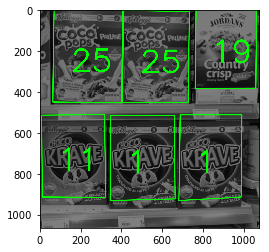



Scene: h1

Product 0 – 2/2 instances found
	Position: (340, 303)	Width: 59	Height: 76
	Position: (276, 314)	Width: 54	Height: 74
Product 1 – 1/1 instances found
	Position: (517, 310)	Width: 55	Height: 72
Product 2 – 2/2 instances found
	Position: (106, 108)	Width: 59	Height: 92
	Position: (36, 107)	Width: 62	Height: 90
Product 3 – 1/2 instances found
	Position: (279, 407)	Width: 52	Height: 81
Product 4 – 1/2 instances found
	Position: (166, 105)	Width: 69	Height: 99
Product 5 – 2/2 instances found
	Position: (299, 99)	Width: 50	Height: 76
	Position: (368, 97)	Width: 45	Height: 70
Product 7 – 2/2 instances found
	Position: (493, 107)	Width: 62	Height: 100
	Position: (430, 106)	Width: 62	Height: 101
Product 8 – 2/2 instances found
	Position: (425, 229)	Width: 53	Height: 70
	Position: (494, 240)	Width: 55	Height: 70
Product 9 – 0/2 instances found
Product 10 – 0/2 instances found
Product 11 – 2/2 instances found
	Position: (456, 314)	Width: 59	Height: 73
	Position: (393, 311)	Width: 53	

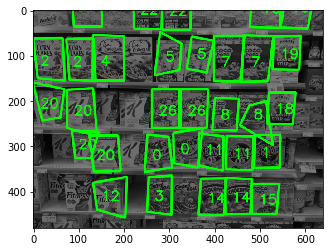



Scene: h2

Product 0 – 2/2 instances found
	Position: (311, 326)	Width: 56	Height: 71
	Position: (254, 326)	Width: 57	Height: 71
Product 1 – 1/1 instances found
	Position: (483, 318)	Width: 58	Height: 74
Product 3 – 3/3 instances found
	Position: (249, 421)	Width: 56	Height: 78
	Position: (363, 422)	Width: 58	Height: 78
	Position: (307, 424)	Width: 55	Height: 77
Product 4 – 2/2 instances found
	Position: (141, 130)	Width: 68	Height: 94
	Position: (203, 132)	Width: 68	Height: 95
Product 5 – 2/2 instances found
	Position: (271, 121)	Width: 43	Height: 67
	Position: (331, 123)	Width: 42	Height: 67
Product 7 – 2/2 instances found
	Position: (394, 131)	Width: 58	Height: 95
	Position: (463, 131)	Width: 58	Height: 94
Product 8 – 0/2 instances found
Product 9 – 1/2 instances found
	Position: (83, 325)	Width: 61	Height: 73
Product 10 – 0/2 instances found
Product 11 – 2/2 instances found
	Position: (368, 329)	Width: 55	Height: 69
	Position: (425, 329)	Width: 56	Height: 69
Product 12 – 0/2 inst

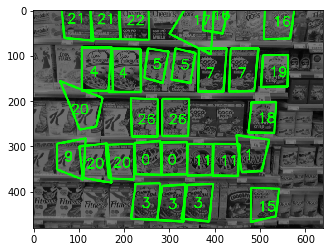



Scene: h3

Product 0 – 2/2 instances found
	Position: (346, 309)	Width: 53	Height: 70
	Position: (404, 312)	Width: 56	Height: 71
Product 1 – 1/1 instances found
	Position: (586, 314)	Width: 59	Height: 71
Product 2 – 1/0 instances found
	Position: (83, 390)	Width: 47	Height: 71
Product 3 – 2/3 instances found
	Position: (455, 409)	Width: 61	Height: 80
	Position: (399, 408)	Width: 57	Height: 77
Product 4 – 2/2 instances found
	Position: (302, 123)	Width: 62	Height: 93
	Position: (243, 121)	Width: 62	Height: 90
Product 5 – 2/2 instances found
	Position: (364, 108)	Width: 44	Height: 66
	Position: (426, 107)	Width: 44	Height: 68
Product 7 – 2/2 instances found
	Position: (565, 114)	Width: 62	Height: 99
	Position: (491, 115)	Width: 61	Height: 98
Product 8 – 2/2 instances found
	Position: (541, 246)	Width: 63	Height: 84
	Position: (471, 228)	Width: 68	Height: 87
Product 9 – 1/2 instances found
	Position: (183, 313)	Width: 54	Height: 65
Product 10 – 0/2 instances found
Product 11 – 2/2 insta

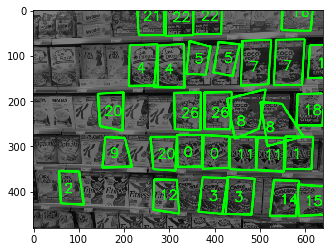



Scene: h4

Product 0 – 0/1 instances found
Product 1 – 1/1 instances found
	Position: (507, 334)	Width: 57	Height: 72
Product 2 – 1/2 instances found
	Position: (85, 130)	Width: 63	Height: 95
Product 3 – 2/2 instances found
	Position: (328, 444)	Width: 60	Height: 88
	Position: (268, 441)	Width: 62	Height: 87
Product 4 – 2/2 instances found
	Position: (150, 128)	Width: 72	Height: 100
	Position: (217, 130)	Width: 70	Height: 100
Product 5 – 3/2 instances found
	Position: (350, 115)	Width: 52	Height: 74
	Position: (289, 120)	Width: 45	Height: 71
	Position: (320, 327)	Width: 54	Height: 95
Product 7 – 2/2 instances found
	Position: (421, 130)	Width: 61	Height: 102
	Position: (483, 128)	Width: 60	Height: 98
Product 8 – 1/2 instances found
	Position: (397, 247)	Width: 68	Height: 74
Product 9 – 1/2 instances found
	Position: (71, 345)	Width: 62	Height: 80
Product 10 – 0/2 instances found
Product 11 – 2/2 instances found
	Position: (447, 337)	Width: 58	Height: 75
	Position: (387, 337)	Width: 5

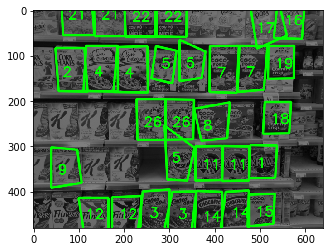



Scene: h5

Product 0 – 2/2 instances found
	Position: (223, 340)	Width: 58	Height: 75
	Position: (283, 337)	Width: 57	Height: 73
Product 1 – 1/1 instances found
	Position: (464, 339)	Width: 58	Height: 77
Product 2 – 1/0 instances found
	Position: (33, 126)	Width: 53	Height: 78
Product 3 – 2/3 instances found
	Position: (278, 444)	Width: 60	Height: 80
	Position: (220, 442)	Width: 58	Height: 80
Product 4 – 1/2 instances found
	Position: (166, 137)	Width: 72	Height: 100
Product 5 – 2/2 instances found
	Position: (235, 125)	Width: 47	Height: 72
	Position: (295, 129)	Width: 56	Height: 80
Product 7 – 2/2 instances found
	Position: (444, 133)	Width: 62	Height: 101
	Position: (368, 136)	Width: 62	Height: 102
Product 8 – 1/2 instances found
	Position: (431, 263)	Width: 38	Height: 67
Product 9 – 1/1 instances found
	Position: (38, 342)	Width: 55	Height: 77
Product 10 – 0/2 instances found
Product 11 – 2/2 instances found
	Position: (343, 345)	Width: 58	Height: 73
	Position: (405, 344)	Width: 5

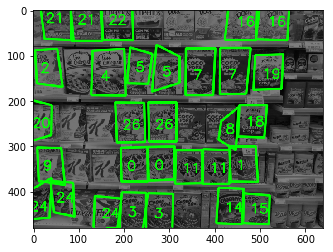

In [17]:
# verbose=False does not print the true negative instances
# color=True outputs all the scenes in color insted of grayscale, but the process is quite slow, therefore it is False by default
step_C(query_imgs, train_imgs, true_imgs, verbose=False, color=False)